In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

random.seed(10)

In [2]:
# Hidden state space
S = [0, 1]
# Emission space
V = [1, 2, 3, 4, 5]
# Transition matrix
A = np.matrix([[0.8, 0.2], 
               [0.1, 0.9]])
# Initial distribution 
mu_0 = [0.5, 0.5]
# Emission matrix
B = np.matrix([[0.2, 0.5, 0.2, 0.1, 0],
               [0, 0.1, 0.4, 0.4, 0.1]])

In [3]:
def writeParametersToFile(S, V, A, mu_0, B, file):
    # Write parameters to file
    f = open(file, "w")
    f.write("State space: " + " ".join(str(s) for s in S) + "\n")
    f.write("Emission space: " + " ".join(str(v) for v in V) + "\n")
    f.write("Transition matrix: " + " ".join(str(a) for a in np.array(A).flatten()) + "\n")
    f.write("Initial distribution: " + " ".join(str(m) for m in mu_0) + "\n")
    f.write("Emission matrix: " + " ".join(str(b) for b in np.array(B).flatten()))
    f.close()

In [4]:
chromosome_file = open("s_cerevisiae_chromosome_III.fa", "r")

bases = "".join([line.strip() for line in chromosome_file.readlines()[1:]])
print("Number of bases: " + str(len(bases)))

Number of bases: 316620


In [5]:
# Split into 100 base pair windows
window_size = 100

split_bases = [bases[i : i + window_size] for i in range(0, len(bases), window_size)]

In [6]:
# Calculate the % of GC in each window
gc_content = [window.count("G") + window.count("C") / len(window) for window in split_bases]

decimal_places = 3

print("GC Statistics")
print("-------------")
print("Mean: " + str(round(np.mean(gc_content), decimal_places)) + "%")
print("Median: " + str(round(np.median(gc_content), decimal_places)) + "%")
print("Standard deviation: " + str(round(np.std(gc_content), decimal_places)) + "%")
print("Minimum: " + str(round(min(gc_content), decimal_places)) + "%")
print("Maximum: " + str(round(max(gc_content), decimal_places)) + "%")
print("-------------")

GC Statistics
-------------
Mean: 19.029%
Median: 18.34%
Standard deviation: 5.547%
Minimum: 0.6%
Maximum: 58.0%
-------------


In [7]:
chromosome_emission = np.ones(len(gc_content))

for i in range(len(gc_content)):
    if 11 < gc_content[i] < 22:
        chromosome_emission[i] = 2
    elif 22 <= gc_content[i] < 33:
        chromosome_emission[i] = 3
    elif 33 <= gc_content[i] < 44:
        chromosome_emission[i] = 4
    elif 44 <= gc_content[i]:
        chromosome_emission[i] = 5

In [119]:
class HMM():
    """
    S: state space
    V: emission space
    A: transition matrix
    mu_0: initial distribution
    B: emission matrix
    N: markov chain length
    """
    
    def __init__(self, S = None, V = None, A = None, mu_0 = None, B = None,
                 N = 100, file = None):
        
        if isinstance(file, type(None)):
            # If no file given, directly set parameters
            self.S = S
            self.V = V
            self.A = A
            self.mu_0 = mu_0
            self.B = B
            
        else:
            # Otherwise read parameters from a file
            f = open(file, "r")
            
            readArray = lambda x: np.array(x.readline().split()[2:]).astype(float)
            readMatrix = lambda x: np.matrix(x.readline().split()[2:]).astype(float)

            self.S = readArray(f)
            self.V = readArray(f)
            self.A = readMatrix(f)
            self.A.shape = (len(self.S), len(self.S))
            self.mu_0 = readArray(f)
            self.B = readMatrix(f)
            self.B.shape = (len(self.S), len(self.V))
            
        # Set the chain length
        self.N = N
        # Number of states
        self.J = len(self.S)

        # Map emitted state values to numerical indexes
        self.emit_idxs = dict(zip(self.V, [i for i in range(len(self.V))]))
        
    def markovChain(self):
        # Create markov chain
        chain = np.zeros(self.N)
        # Set the first state by sampling from the initial distribution
        chain[0] = np.random.choice(self.S, p = self.mu_0)
        
        # Set the remaining states in the chain
        for i in range(1, self.N):
            # Get the probability row from the transition matrix
            state_prob = np.array(self.A[int(chain[i - 1])]).flatten()
            # Sample from the state space
            chain[i] = np.random.choice(self.S, p = state_prob)
        
        return(chain)
    
    def emitStates(self, markov_chain):
        # Create output sequence
        emission = np.zeros(self.N)
        
        for i in range(self.N):
            # Get the probability row from the emission matrix
            emit_prob = np.array(self.B[int(markov_chain[i])]).flatten()
            # Sample from the emission matrix
            emission[i] = np.random.choice(self.V, p = emit_prob)
            
        return(emission)
    
    # Scaled forward algorithm
    def forwardAlgorithm(self, emitted_sequence):
        # Initialise forward variables (alpha) and scale c
        a_hat = np.matrix(np.zeros((self.J, self.N)), dtype = np.longfloat)
        c = np.zeros(self.N, dtype = np.longfloat)
        
        # Map emitted sequence values to numerical indexes
        sequence_idxs = [self.emit_idxs[x] for x in emitted_sequence]
        v0 = int(sequence_idxs[0])
        
        a_hat[:, 0] = np.multiply(self.B[:, v0], self.mu_0[:].reshape(self.J, 1))
        c[0] = sum(np.multiply(np.array(self.B[:, v0]).flatten(), self.mu_0[:]))
        
        # Divide alphas by scaling factor
        for i in range(self.J):
            a_hat[i, 0] = a_hat[i, 0] / c[0]
            
        for n in range(1, self.N):
            # Get emission at position n
            vn = int(sequence_idxs[n])
            
            for i in range(self.J):
                # Calculate scale
                c[n] += self.B[i, vn] * sum(np.multiply(a_hat[:, n - 1], self.A[:, i]))
            
            for i in range(self.J):
                # Calculate scaled alpha
                a_hat[i, n] = (1/c[n]) * (self.B[i, vn] * sum(np.multiply(a_hat[:, n - 1], self.A[:, i])))
                
        # Calculate probability of data
        L = 0
        
        for n in range(self.N):
            L += math.log(c[n])
            
        return(L, a_hat, c)
    
    def backwardAlgorithm(self, emitted_sequence, c):
        # Initialise scaled backward variable
        b_hat = np.matrix(np.zeros((self.J, self.N)), dtype = np.longfloat)
        
        # Map emitted sequence values to numerical indexes
        sequence_idxs = [self.emit_idxs[x] for x in emitted_sequence]
        
        # Set inital values for BNi to BNj
        b_hat[:, self.N - 1] = 1/c[self.N - 1]
        
        for n in range(self.N - 2, -1, -1):
            # Get emission at position n
            vn = int(sequence_idxs[n])
            
            for i in range(self.J):
                # Calculate scaled backward variable
                b_hat[i, n] = (1/c[n]) * (self.B[i, vn] * sum(np.multiply(b_hat[:, n + 1], self.A[:, i])))
                
        return(b_hat)
    
    def generateProbability(self, size):
        # Generate random numbers
        probability = [random.randint(1, 10) for i in range(size)]
        # Scale between 0 - 1
        probability = np.array([float(i) / sum(probability) for i in probability])
        
        return(probability)
    
    def BaumWelchAlgorithm(self, emitted_sequence, threshold):
        # Initialise parameters theta
        self.A = np.matrix(self.generateProbability(len(self.S)))
        self.mu_0 = self.generateProbability(len(self.S))
        self.B = np.matrix(self.generateProbability(len(self.V)))
        
        while self.A.shape[0] != len(self.S):
            self.A = np.vstack([self.A, self.generateProbability(len(self.S))])
            self.B = np.vstack([self.B, self.generateProbability(len(self.V))])

        # Map emitted sequence values to numerical indexes
        sequence_idxs = [self.emit_idxs[x] for x in emitted_sequence]
        v1 = int(sequence_idxs[1])
            
        # Initialise log likelihood
        L = float("inf")
        L_change = float("inf")
        
        # Calculate likelihood for initial parameters
        L_new, a_hat, c = self.forwardAlgorithm(emitted_sequence)
        b_hat = self.backwardAlgorithm(emitted_sequence, c)
        
        while (L_change > threshold):
            # Save previous state of A and B
            A = np.copy(self.A)
            B = np.copy(self.B)
            self.B = np.zeros_like(self.B)
            
            for i in range(self.J):
                for j in range(self.J):
                    self.A[i, j] = np.sum(A[i, j] * np.multiply(np.multiply(a_hat[i, :-1],
                                                                            np.array([B[j, idx] for idx in sequence_idxs[1:]])),
                                                                b_hat[j, 1:]))
                
                    for vk in range(len(self.V)):
                        emitted_states = np.zeros_like(sequence_idxs)
                        state_idxs = [i for i, e in enumerate(sequence_idxs) if e == vk]
                        emitted_states[state_idxs] = 1
                        self.B[i, vk] += np.sum(A[i, j] * np.multiply(np.multiply(a_hat[i, :-1],
                                                                          np.array([B[j, idx] for idx in sequence_idxs[1:]])),
                                                              np.multiply(b_hat[j, 1:],
                                                                          emitted_states[:-1]))) # HERE
                # Divide by expectation
                self.B[i, :] = np.divide(self.B[i, :], np.sum(self.A[i, :]))
                self.A[i, :] = np.divide(self.A[i, :], np.sum(self.A[i, :]))
                
                # Normalise between 0 - 1 to account for underflow / rounding errors
#                 self.A[i, :] = np.array([float(i) / sum(self.A[i, :]) for i in self.A[i, :]])
#                 self.B[i, :] = np.array([float(i) / sum(self.B[i, :]) for i in self.B[i, :]])
                    
                # Calculate updated mu
                self.mu_0[i] = a_hat[i, 0] * sum(np.array(np.multiply(np.multiply(A[i, :],
                                                                                  B[:, v1].flatten()),
                                                                      b_hat[:, 1].flatten())).flatten())
                
            # Normalise between 0 - 1 to account for underflow / rounding errors
            self.mu_0 = np.array([float(i) / sum(self.mu_0) for i in self.mu_0])
            
            # Calculate likelihood for new parameters
            L_new, a_hat, c = self.forwardAlgorithm(emitted_sequence)
            b_hat = self.backwardAlgorithm(emitted_sequence, c)
        
            # Difference in likelihood between previous and updated paramaters
            L_change = abs(L - L_new)
            L = L_new

        return(L)
    
    def ViterbiAlgorithm(self, emitted_sequence):
        # Viterbi sequence, traceback pointer and best states
        phi = np.matrix(np.zeros((self.J, self.N)), dtype = np.longfloat)
        psi = np.matrix(np.zeros((self.J, self.N)), dtype = np.longfloat)
        best_states = np.array(np.zeros(self.N))
        
        # Map emitted sequence values to numerical indexes
        sequence_idxs = [self.emit_idxs[x] for x in emitted_sequence]
        v0 = int(sequence_idxs[0])
        
        # Initialise first viterbi variable
        phi[:, 0] = np.reshape(np.array([math.log(m) for m in self.mu_0]) + np.array([math.log(b) for b in self.B[:, v0]]),
                        (self.J, 1))
        
        for n in range(1, self.N):
            # Get the value at position n in the emitted sequence
            vn = int(sequence_idxs[n])
            
            # Set the remaining viterbi variables
            for i in range(self.J):
                phi[i, n] = math.log(self.B[i, vn]) + max(np.array([math.log(self.A[i, j]) + phi[j, n - 1] for j in range(self.J)]))
                psi[i, n] = np.argmax(np.array([math.log(self.A[i, j]) + phi[j, n - 1] for j in range(self.J)]))
                
        # Traceback to find the best fitting states
        best_states[self.N - 1] = np.argmax([phi[i, self.N - 1] for i in range(self.J)])
        
        for n in range(self.N - 2, -1, -1):
            best_states[n] = psi[int(best_states[n + 1]), n + 1]
            
        return(best_states)

In [63]:
hmm = HMM(file = "hmm_params.txt", N = 115)
# Create the markov chain
m_chain = hmm.markovChain()
# Get the emitted states
emitted_sequence = hmm.emitStates(m_chain)
log_likelihood, _, _ = hmm.forwardAlgorithm(emitted_sequence)

print("Emitted sequence: " + str(emitted_sequence))
print("Log Likelihood: " + str(log_likelihood))

Emitted sequence: [2. 3. 5. 3. 5. 3. 2. 4. 2. 3. 3. 1. 3. 3. 4. 3. 3. 2. 4. 2. 3. 3. 3. 2.
 5. 4. 2. 3. 4. 2. 2. 4. 2. 1. 2. 4. 2. 4. 3. 4. 3. 4. 2. 4. 2. 3. 3. 4.
 2. 3. 2. 4. 2. 4. 2. 3. 4. 3. 4. 4. 3. 4. 2. 1. 2. 2. 4. 2. 4. 3. 4. 2.
 3. 3. 3. 3. 5. 3. 3. 4. 3. 3. 3. 4. 5. 4. 4. 3. 3. 4. 3. 2. 2. 2. 3. 3.
 5. 5. 2. 3. 3. 4. 3. 3. 5. 4. 3. 5. 4. 3. 4. 4. 3. 5. 3.]
Log Likelihood: -160.0099681889621


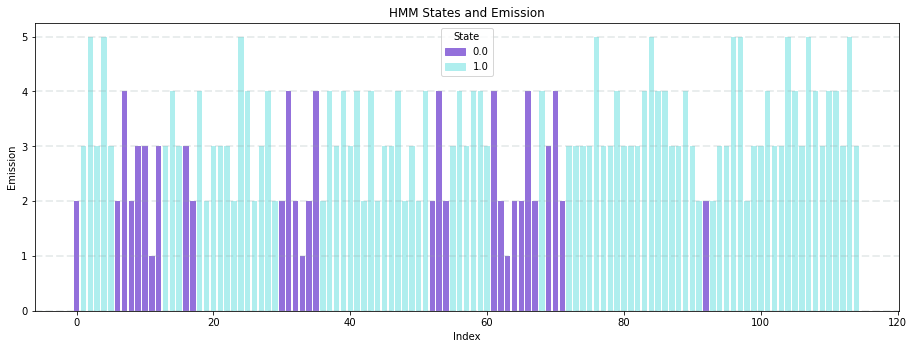

In [79]:
colour_dict = {0: "mediumpurple", 1: "paleturquoise", 2: "yellow", 3: "greenyellow", 4: "purple"}

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar([i for i in range(len(emitted_sequence))], emitted_sequence, color = [colour_dict[int(s)] for s in m_chain])
plt.grid(color = '#95a5a6', linestyle = '--', linewidth = 2, axis = 'y', alpha = 0.2)
plt.title('HMM States and Emission')
plt.xlabel('Index')
plt.ylabel('Emission')

plt.legend(handles = [mpatches.Patch(color = colour_dict[i],
                                     label = np.unique(m_chain)[i]) for i in range(len(np.unique(m_chain)))],
           title = "State")
#plt.savefig(".pdf", bbox_inches = 'tight')
plt.show()

In [118]:
hmm_chromosome = HMM(file = "hmm_params.txt", N = len(chromosome_emission))
log_likelihood, _, _ = hmm_chromosome.forwardAlgorithm(chromosome_emission)

print("Log Likelihood: " + str(log_likelihood))

new_log_likelihood = hmm_chromosome.BaumWelchAlgorithm(chromosome_emission, threshold = 0.5)

print("Updated Log Likelihood: " + str(new_log_likelihood))

predicted_state = hmm_chromosome.ViterbiAlgorithm(chromosome_emission)

print("Predicted states: " + str(predicted_state))

Log Likelihood: -3581.347726590954
Updated Log Likelihood: -2627.633900845322
[[0. 1. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]]
Predicted states: [1. 1. 1. ... 1. 1. 1.]


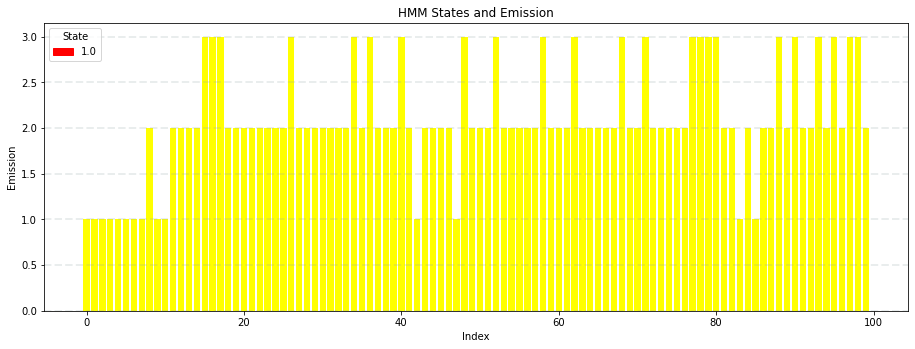

In [116]:
colour_dict = {0: "red", 1: "yellow", 2: "green", 3: "blue"}

min_position = 0
max_position = 100

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar([i for i in range(len(chromosome_emission[min_position : max_position]))],
       chromosome_emission[min_position : max_position],
       color = [colour_dict[int(s)] for s in predicted_state[min_position : max_position]])
plt.grid(color = '#95a5a6', linestyle = '--', linewidth = 2, axis = 'y', alpha = 0.2)
plt.title('HMM States and Emission')
plt.xlabel('Index')
plt.ylabel('Emission')

plt.legend(handles = [mpatches.Patch(color = colour_dict[i],
                                     label = np.unique(predicted_state[min_position : max_position])[i])
                      for i in range(len(np.unique(predicted_state[min_position : max_position])))],
           title = "State")
#plt.savefig(".pdf", bbox_inches = 'tight')
plt.show()